<a href="https://colab.research.google.com/github/DrewRust/DS-Unit-2-Kaggle-Challenge/blob/master/U2S2M4_Andrew_Rust_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

### Only run this cell for Improving Kaggle Challenge portion towards middle of this assignment

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

###Plot a confusion matrix for your Tanzania Waterpumps model.

In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Merge train_features.csv & train_labels.csv
train_for_testing = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
train_for_testing = wrangle(train_for_testing)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

X_train_for_testing = train_for_testing.drop(columns=target)
y_train_for_testing = train_for_testing[target]

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_estimators is number of trees in the forest
)


In [21]:
# Fit on train, score on val
pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                               

In [22]:
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Validation accuracy: 0.8140409527789386


In [0]:
# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

In [8]:
submission_czag = test[['id']].copy()
submission_czag

,id
0,50785
1,51630
2,17168
3,45559
4,49871
...,...
14353,39307
14354,18990
14355,28749
14356,33492


In [0]:
submission_czag['status_group'] = y_pred
submission_czag.to_csv('my_submission_czag.csv', index=False)

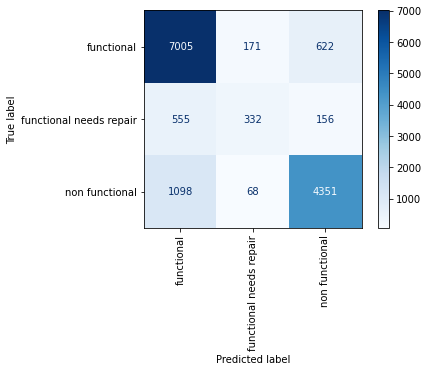

In [0]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val,
                      values_format='.0f', xticks_rotation='vertical', cmap='Blues')

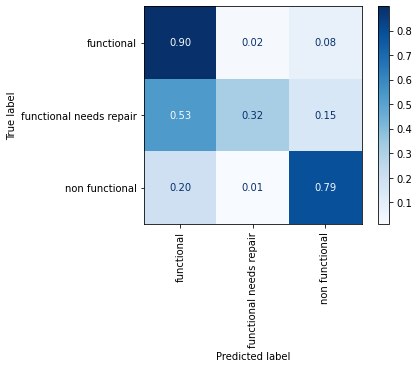

In [0]:
plot_confusion_matrix(pipeline, X_val, y_val,
                      normalize='true',
                      values_format='.2f', 
                      xticks_rotation='vertical', cmap='Blues')

###Improve Kaggle Challenge

###Below is an example

In [0]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

In [0]:
# Look for more duplicate / near duplicate columns, besides quanity_group & quantity.
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,59400,1,GeoData Consultants Ltd,59400
public_meeting,56066,2,True,51011
permit,56344,2,True,38852
status_group,59400,3,functional,32259
source_class,59400,3,groundwater,45794
quantity_group,59400,5,enough,33186
quantity,59400,5,enough,33186
management_group,59400,5,user-group,52490
quality_group,59400,6,good,50818
waterpoint_type_group,59400,6,communal standpipe,34625


In [0]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [0]:
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
# Reduce cardinality for region feature ...
 
# Get a list of the top 10 regions
top10 = train['region'].value_counts()[:10].index

In [0]:
# At locations where the region is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['region'].isin(top10), 'region'] = 'OTHER'
val.loc[~val['region'].isin(top10), 'region'] = 'OTHER'
test.loc[~test['region'].isin(top10), 'region'] = 'OTHER'

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['num_private', 'amount_tsh', 'population', 'construction_year', 
                       'gps_height', 'permit', 'public_meeting', 'longitude', 'district_code',
                       'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'extraction_type_class', 
                  'extraction_type_group', 'scheme_management', 
                  'payment_type', 'quality_group', 'waterpoint_type_group']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
   
    # return the wrangled dataframe
    return X

In [0]:
train = wrangle(train)
val = wrangle(val)
test2 = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=target)

# Get a list of the numeric features
numeric_features = train.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 30].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years', 'basin', 'region', 'public_meeting', 'permit', 'extraction_type', 'management', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'num_private_MISSING', 'amount_tsh_MISSING', 'population_MISSING', 'construction_year_MISSING', 'gps_height_MISSING', 'permit_MISSING', 'public_meeting_MISSING', 'longitude_MISSING', 'district_code_MISSING', 'latitude_MISSING']


In [0]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test2

In [0]:
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [0]:
pipeline = make_pipeline(
    # ce.ordinal.OrdinalEncoder(),
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy="median"),
    RandomForestClassifier(n_estimators=190, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')
y_pred = pipeline.predict(X_test)
# Validation accuracy: 0.8142255892255892 (175)n_estimators